# Test transmission performance metrics for the AWGN channel

In [ ]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install 

In [1]:
from optic.modulation import modulateGray, GrayMapping
from optic.metrics import signal_power, monteCarloGMI, monteCarloMI, fastBERcalc, theoryBER
from optic.models import awgn
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from tqdm.notebook import tqdm
from numba import njit

In [3]:
%load_ext autoreload
%autoreload 2
#%load_ext line_profiler

## Test bit-error-rate (BER) versus signal-to-noise ratio per bit ($E_b/N_0$)

### QAM constellations with Gray mapping

In [4]:
# Run BER vs Ebn0 Monte Carlo simulation in the AWGN channel

qamOrder  = [4, 16, 64, 256, 1024, 4096]  # Modulation order

EbN0dB_  = np.arange(-2, 35, 1)
BER      = np.zeros((len(EbN0dB_),len(qamOrder)))
BER[:]   = np.nan

for ii, M in enumerate(qamOrder):
    print('run sim: M = ', M)
    for indSNR in tqdm(range(EbN0dB_.size)):

        EbN0dB = EbN0dB_[indSNR]

        # generate random bits
        bitsTx = np.random.randint(2, size=2*3*5*2**15)    

        # Map bits to constellation symbols
        symbTx = modulateGray(bitsTx, M, 'qam')

        # Normalize symbols energy to 1
        symbTx = symbTx/np.sqrt(signal_power(symbTx))

        # AWGN channel  
        snrdB  = EbN0dB + 10*np.log10(np.log2(M))
        symbRx = awgn(symbTx, snrdB)

        # BER calculation
        BER[indSNR, ii], _, _ = fastBERcalc(symbRx, symbTx, M, 'qam')
        
        if BER[indSNR, ii] == 0:              
            break

run sim: M =  4


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  16


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  64


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  256


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  1024


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  4096


  0%|          | 0/37 [00:00<?, ?it/s]

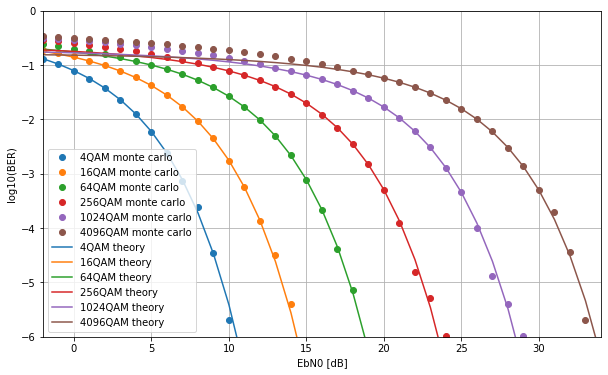

In [5]:
# Plot simulation results and theoretical curves        
BER[BER==0] = np.nan

plt.figure(figsize=(10,6))
for ii, M in enumerate(qamOrder):
    plt.plot(EbN0dB_, np.log10(BER[:,ii]),'o', label=str(M)+'QAM monte carlo')

plt.gca().set_prop_cycle(None)

for M in qamOrder:
    BERtheory = theoryBER(M, EbN0dB_,'qam')
    BERtheory[BERtheory==0] = np.nan
    plt.plot(EbN0dB_, np.log10(BERtheory),'-', label=str(M)+'QAM theory')

plt.xlim(min(EbN0dB_), max(EbN0dB_))
plt.ylim(-6, 0)
plt.legend();
plt.xlabel('EbN0 [dB]');
plt.ylabel('log10(BER)');
plt.grid()

### PSK constellations with Gray mapping

In [6]:
# Run BER vs Ebn0 Monte Carlo simulation 

pskOrder  = [4, 8, 16, 32, 64]  # Modulation order

EbN0dB_  = np.arange(-2, 35, 1)
BER      = np.zeros((len(EbN0dB_),len(pskOrder)))
BER[:]   = np.nan

for ii, M in enumerate(pskOrder):
    print('run sim: M = ', M)
    for indSNR in tqdm(range(EbN0dB_.size)):

        EbN0dB = EbN0dB_[indSNR]

        # generate random bits
        bitsTx = np.random.randint(2, size=2*3*5*2**15)    

        # Map bits to constellation symbols
        symbTx = modulateGray(bitsTx, M, 'psk')

        # Normalize symbols energy to 1
        symbTx = symbTx/np.sqrt(signal_power(symbTx))

        # AWGN channel  
        snrdB  = EbN0dB + 10*np.log10(np.log2(M))
        symbRx = awgn(symbTx, snrdB)

        # BER calculation
        BER[indSNR, ii], _, _ = fastBERcalc(symbRx, symbTx, M, 'psk')
        
        if BER[indSNR, ii] == 0:              
            break

run sim: M =  4


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  8


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  16


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  32


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  64


  0%|          | 0/37 [00:00<?, ?it/s]

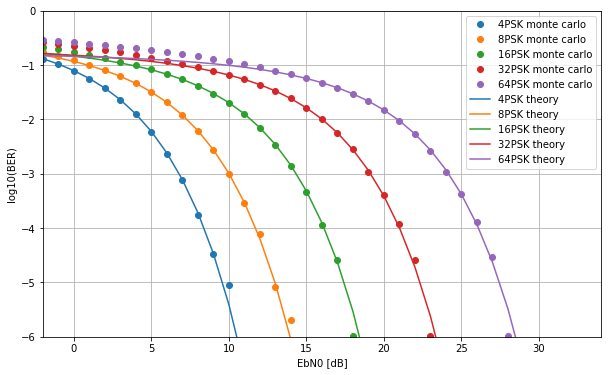

In [7]:
# Plot simulation results and theoretical curves        
BER[BER==0] = np.nan

plt.figure(figsize=(10,6))
for ii, M in enumerate(pskOrder):
    plt.plot(EbN0dB_, np.log10(BER[:,ii]),'o', label=str(M)+'PSK monte carlo')

plt.gca().set_prop_cycle(None)

for M in pskOrder:
    BERtheory = theoryBER(M, EbN0dB_,'psk')
    BERtheory[BERtheory==0] = np.nan
    plt.plot(EbN0dB_, np.log10(BERtheory),'-', label=str(M)+'PSK theory')

plt.xlim(min(EbN0dB_), max(EbN0dB_))
plt.ylim(-6, 0)
plt.legend();
plt.xlabel('EbN0 [dB]');
plt.ylabel('log10(BER)');
plt.grid()

## Test generalized mutual information (GMI) versus signal-to-noise ratio (SNR)

### QAM constellations with Gray mapping

In [8]:
# Run GMI vs SNR Monte Carlo simulation 

qamOrder  = [4, 16, 64, 256, 1024, 4096]  # Modulation order

SNR  = np.arange(-2, 35, 1)
GMI  = np.zeros((len(SNR),len(qamOrder)))

for ii, M in enumerate(qamOrder):
    print('run sim: M = ', M)
    for indSNR in tqdm(range(SNR.size)):

        snrdB = SNR[indSNR]

        # generate random bits
        bitsTx   = np.random.randint(2, size=2*3*5*2**14)    

        # Map bits to constellation symbols
        symbTx = modulateGray(bitsTx, M, 'qam')

        # Normalize symbols energy to 1
        symbTx = symbTx/np.sqrt(signal_power(symbTx))

        # AWGN channel       
        symbRx = awgn(symbTx, snrdB)

        # GMI estimation
        GMI[indSNR, ii], _  = monteCarloGMI(symbRx, symbTx, M, 'qam')

run sim: M =  4


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  16


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  64


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  256


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  1024


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  4096


  0%|          | 0/37 [00:00<?, ?it/s]

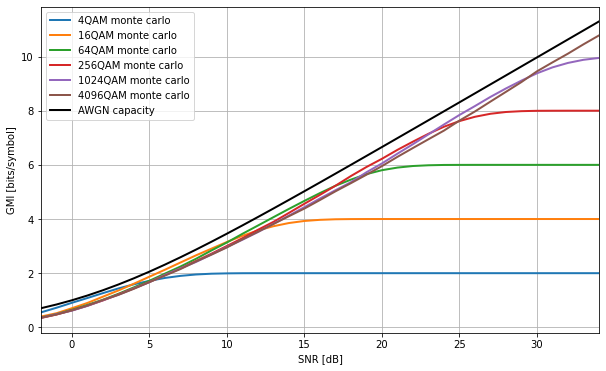

In [9]:
plt.figure(figsize=(10,6))
for ii, M in enumerate(qamOrder):
    plt.plot(SNR, GMI[:,ii],'-', label=str(M)+'QAM monte carlo',linewidth=2)

# plot theoretical AWGN channel capacity    
C = np.log2(1 + 10**(SNR/10))
plt.plot(SNR, C,'k-', label='AWGN capacity',linewidth=2)


plt.xlim(min(SNR), max(SNR))
plt.legend();
plt.xlabel('SNR [dB]');
plt.ylabel('GMI [bits/symbol]');
plt.grid()

### PSK constellations with Gray mapping

In [10]:
# Run GMI vs SNR Monte Carlo simulation 

pskOrder  = [4, 8, 16, 32, 64]  # Modulation order

SNR  = np.arange(-2, 35, 1)
GMI  = np.zeros((len(SNR),len(pskOrder)))

for ii, M in enumerate(pskOrder):
    print('run sim: M = ', M)
    for indSNR in tqdm(range(SNR.size)):

        snrdB = SNR[indSNR]

        # generate random bits
        bitsTx   = np.random.randint(2, size=2*3*5*2**14)    

        # Map bits to constellation symbols
        symbTx = modulateGray(bitsTx, M, 'psk')

        # Normalize symbols energy to 1
        symbTx = symbTx/np.sqrt(signal_power(symbTx))

        # AWGN channel       
        symbRx = awgn(symbTx, snrdB)

        # GMI estimation
        GMI[indSNR, ii], _  = monteCarloGMI(symbRx, symbTx, M, 'psk')

run sim: M =  4


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  8


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  16


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  32


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  64


  0%|          | 0/37 [00:00<?, ?it/s]

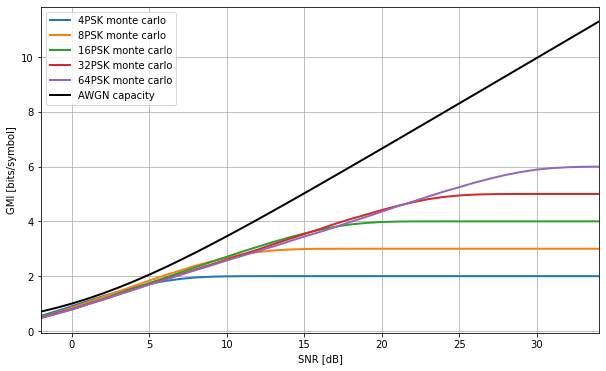

In [11]:
plt.figure(figsize=(10,6))
for ii, M in enumerate(pskOrder):
    plt.plot(SNR, GMI[:,ii],'-', label=str(M)+'PSK monte carlo',linewidth=2)

# plot theoretical AWGN channel capacity    
C = np.log2(1 + 10**(SNR/10))
plt.plot(SNR, C,'k-', label='AWGN capacity',linewidth=2)


plt.xlim(min(SNR), max(SNR))
plt.legend();
plt.xlabel('SNR [dB]');
plt.ylabel('GMI [bits/symbol]');
plt.grid()

## Test mutual information (MI) versus signal-to-noise ratio (SNR)

### QAM constellations with Gray mapping

In [12]:
# Run MI vs SNR Monte Carlo simulation 

qamOrder  = [4, 16, 64, 256, 1024]  # Modulation order

SNR  = np.arange(-2, 35, 1)
MI  = np.zeros((len(SNR),len(qamOrder)))

for ii, M in enumerate(qamOrder):
    print('run sim: M = ', M)         
            
    for indSNR in tqdm(range(SNR.size)):

        snrdB = SNR[indSNR]

        # generate random bits
        bitsTx   = np.random.randint(2, size=2*3*5*2**14)    

        # Map bits to constellation symbols
        symbTx = modulateGray(bitsTx, M, 'qam')

        # Normalize symbols energy to 1
        symbTx = symbTx/np.sqrt(signal_power(symbTx))

        # AWGN channel        
        symbRx = awgn(symbTx, snrdB)

        # MI estimation
        MI[indSNR, ii] = monteCarloMI(symbRx, symbTx, M, 'qam')

run sim: M =  4


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  16


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  64


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  256


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  1024


  0%|          | 0/37 [00:00<?, ?it/s]

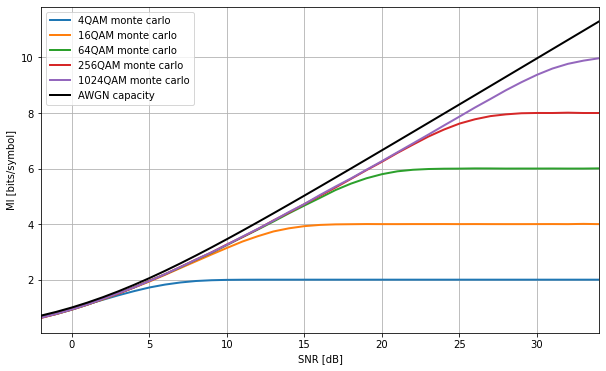

In [13]:
plt.figure(figsize=(10,6))

for ii, M in enumerate(qamOrder):
    plt.plot(SNR, MI[:,ii],'-', label=str(M)+'QAM monte carlo',linewidth=2)

# plot theoretical AWGN channel capacity    
C = np.log2(1 + 10**(SNR/10))
plt.plot(SNR, C,'k-', label='AWGN capacity',linewidth=2)


plt.xlim(min(SNR), max(SNR))
plt.legend();
plt.xlabel('SNR [dB]');
plt.ylabel('MI [bits/symbol]');
plt.grid()

## Test mutual information (MI) versus signal-to-noise ratio (SNR) with probabilistically shaped QAM constellation

In [6]:
from numpy.random import choice

def maxwellBolt(λ, const):
    
    p = np.zeros(const.size)
    
    for ind, x in enumerate(const):
        p[ind] = np.exp(-λ*np.abs(x)**2)
        
    p = p/np.sum(p)
    
    return p   

run sim: M =  64


  0%|          | 0/36 [00:00<?, ?it/s]

run sim: M =  64


  0%|          | 0/36 [00:00<?, ?it/s]

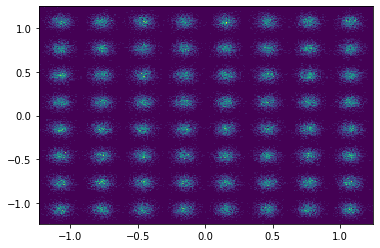

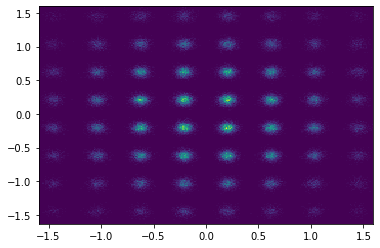

In [7]:
# Run MI vs SNR Monte Carlo simulation 

qamOrder  = [64, 64]  # Modulation order

SNR  = np.arange(-2, 34, 1)
MI  = np.zeros((len(SNR),len(qamOrder)))
Nsymbols = 80000

PS = 0
for ii, M in enumerate(qamOrder):
    print('run sim: M = ', M)
          
    constSymb = GrayMapping(M, 'qam')
    Es = np.mean(np.abs(constSymb) ** 2)
    constSymb = constSymb / np.sqrt(Es)
    
    probSymb = maxwellBolt(PS, constSymb)    
    PS = 1.5
    
    Es = np.sum(( np.abs(constSymb) ** 2 ) * probSymb)
    
    for indSNR in tqdm(range(SNR.size)):

        snrdB = SNR[indSNR]

        # generate random symbols   
        symbTx = choice(constSymb, Nsymbols, p=probSymb)           
       
        # AWGN channel       
        symbRx = awgn(symbTx, snrdB)      
            
        # MI estimation
        MI[indSNR, ii] = monteCarloMI(symbRx, symbTx, M, 'qam', probSymb)       
        
        if indSNR == len(SNR)-10:
            plt.figure()
            plt.hist2d(symbRx.real,symbRx.imag, bins=256, density=True);

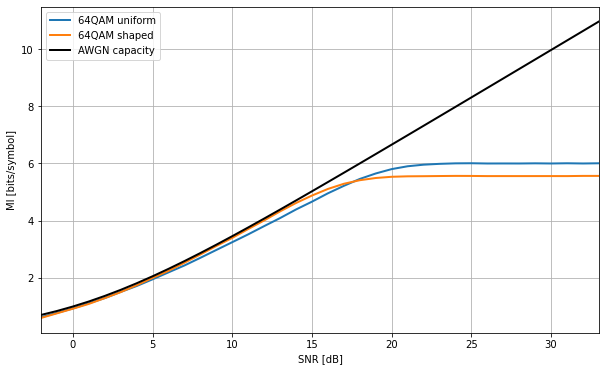

In [8]:
plt.figure(figsize=(10,6))

for ii, M in enumerate(qamOrder):
    if ii == 0:
        pltLabel = 'QAM uniform'
    else:
        pltLabel = 'QAM shaped'
        
    plt.plot(SNR, MI[:,ii],'-', label=str(M)+pltLabel,linewidth=2)

# plot theoretical AWGN channel capacity    
C = np.log2(1 + 10**(SNR/10))
plt.plot(SNR, C,'k-', label='AWGN capacity',linewidth=2)


plt.xlim(min(SNR), max(SNR))
plt.legend();
plt.xlabel('SNR [dB]');
plt.ylabel('MI [bits/symbol]');
plt.grid()